In [21]:
from chain_model.extraction_day_chain import day_chain
from chain_model.extraction_loacation_chain import location_chain
from chain_model.extraction_schedule_or_place_chain import sch_or_place_chain
from chain_model.place_search_chain import place_search_chain
from chain_model.schedule_chain import schedule_chain
from chain_model.discrimination_language import discrimination_language
from chain_model.translation_question import translation_question


from dotenv import load_dotenv
load_dotenv()

from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from operator import itemgetter
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
import ast
import os
import random





embeddings = OpenAIEmbeddings()

# BASE_DIR은 현재 파일이 위치한 디렉토리를 기준으로 설정
BASE_DIR = os.getcwd()

# FAISS 인덱스 파일 경로를 리스트에 추가
faiss_index_paths = []
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_gangnam_faiss"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_jongro_faiss"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_Junggu_faiss"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_yongsan_faiss"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_gangnam_all"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_jongro_all"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_junggu_all"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_yongsan_all"))

# FAISS 인덱스를 로드하고 리트리버를 생성
retrieves = []
for path in faiss_index_paths:
    retrieves.append(FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True).as_retriever())

# 각 리트리버를 변수에 할당
retriever_naver_gangnam = retrieves[0]
retriever_naver_jongro = retrieves[1]
retriever_naver_Junggu = retrieves[2]
retriever_naver_yongsan = retrieves[3]
retriever_opendata_gangnam = retrieves[4]
retriever_opendata_jongro = retrieves[5]
retriever_opendata_junggu = retrieves[6]
retriever_opendata_yongsan = retrieves[7]

# 리트리버의 검색 매개변수를 설정 (검색 결과의 개수)
retriever_naver_gangnam.search_kwargs = {"k": 50}
retriever_naver_jongro.search_kwargs = {"k": 50}
retriever_naver_Junggu.search_kwargs = {"k": 50}
retriever_naver_yongsan.search_kwargs = {"k": 50}
retriever_opendata_gangnam.search_kwargs = {"k": 50}
retriever_opendata_jongro.search_kwargs = {"k": 50}
retriever_opendata_junggu.search_kwargs = {"k": 50}
retriever_opendata_yongsan.search_kwargs = {"k": 50}

    # GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[List[str], add_messages]  # 질문(누적되는 list)
    context_naver_gangnam: Annotated[List, "context_naver_gangnam"]  # 문서의 검색 결과
    context_naver_jongro: Annotated[List, "context_naver_jongro"]  # 문서의 검색 결과
    context_naver_Junggu: Annotated[List, "context_naver_Junggu"]  # 문서의 검색 결과
    context_naver_yongsan: Annotated[List, "context_naver_yongsan"]  # 문서의 검색 결과
    context_opendata: Annotated[List, "context_opendata"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    webOrRetriever: Annotated[str, "webOrRetriever"]  # 웹 or 리트리버 검색
    ScheduleOrplace: Annotated[str, "ScheduleOrplace"]  # 일정 or 장소
    location: Annotated[str, "location"]  # 지역 리스트
    dayCheck: Annotated[str, "dayCheck"]  # 몇일 여행?
    languageCheck: Annotated[str, "languageCheck"]  # 언어판별
    translated_question: Annotated[str, "translated_question"]  # 번역된 질문
    location_error: Annotated[int, "location_error"]  # 장소 에러
    day_error: Annotated[int, "day_error"]  # 여행 일 수 에러
    language_error: Annotated[int, "language_error"]  # 언어 에러
    error_or_normal: Annotated[str, "error_or_normal"]  # 언어 에러
    


####-----노드 함수--------#####

def language_check_is_normal(state):
    pass

def day_locatoin_check(state):
    pass

def translate_question(state: GraphState) -> GraphState:
    chain_translation_question = translation_question()
    response = chain_translation_question.invoke(
        {
        "question": state["question"][-1].content
        }
    )

    return {"translated_question": response}

def language_check(state: GraphState) -> GraphState:
    chain_discrimination_language = discrimination_language()
    response = chain_discrimination_language.invoke(
        {"question": state["question"][-1].content}
    )

    return {"languageCheck": response}

def Schedule_day_check(state: GraphState) -> GraphState:
    chain_day = day_chain()
    response = chain_day.invoke(
        {"question": state["question"][-1].content}
    )

    return {"dayCheck": response}

# 장소검색 or 일정 검색
def Schedule_or_place_check(state: GraphState) -> GraphState:
    # 관련성 체크를 실행("yes" or "no")
    chain_sch_or_placeSearch = sch_or_place_chain()
    response = chain_sch_or_placeSearch.invoke(
        {"question": state["question"][-1].content}
    )

    return {"ScheduleOrplace": response}


# 일정 장소검색 리트리버 분기 체크하는 함수(router)
def is_place(state: GraphState) -> GraphState:
    if state["ScheduleOrplace"] == "일정":
        return "일정"
    else:
        return "장소검색"
    

def error_check(state: GraphState) -> GraphState:

    error_or_normal_chain = error_or_normal_chain()
    response = error_or_normal_chain.invoke(
        {
            "state_loction": state["location_error"],
            "state_day": state["day_error"],
            "state_language": state["language_error"],
            "question" : state["question"][-1].content
        }
    )

    return {"error_or_normal": response}


#  분기 체크하는 함수(router)
def is_error(state: GraphState) -> GraphState:
    if state["error_or_normal"] == "에러":
        return "에러"
    else:
        return "정상"
    
def is_language_error(state: GraphState) -> GraphState:
    if state["languageCheck"] == "언어정보없음":
        return "에러"
    else:
        return "정상"
    
# 지역 판별
def location_check(state: GraphState) -> GraphState:

    chain_location = location_chain()

    response = chain_location.invoke(
        {"question": state["question"][-1].content}
    )

    return {"location": response}

def error_handling(state: GraphState) -> GraphState:
    state_loction = state["location_error"]
    state_day = state["day_error"]
    state_language = state["language_error"]
    language = state['languageCheck']
    latest_question = state["question"][-1].content


    error_handle_chain = error_handle_chain()
    response = error_handle_chain.invoke(
        {
            "state_loction": state_loction,
            "state_day": state_day,
            "state_language": state_language,
            "language" : language,
            "question" : latest_question

        }
    )

    return {"translated_question": response}

    
# 문서 검색 노드--------------------------------------------------------------------------------------------------------------------------
def retrieve_document_naver(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["translated_question"]
    location_str = state['location']

    try : location = ast.literal_eval(location_str)
    except : return {'location_error' : 1}

    if len(location) == 0:
        return {'location_error' : 1}

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다. 
    yongsan = '용산구'
    jonglo = '종로구'
    gangman = '강남구'
    junggu = '중구'
    retrieved_docs_yongsan = []
    retrieved_docs_jongro = []
    retrieved_docs_gangman = []
    retrieved_docs_junggu = []

    if yongsan in location:
        retrieved_docs_yongsan = retriever_naver_yongsan.invoke(latest_question)


    if jonglo in location:
        retrieved_docs_jongro = retriever_naver_jongro.invoke(latest_question)


    if gangman in location:
        retrieved_docs_gangman = retriever_naver_gangnam.invoke(latest_question)


    if junggu in location:
        retrieved_docs_junggu = retriever_naver_Junggu.invoke(latest_question)

    return {"context_naver_gangnam": retrieved_docs_gangman,
            "context_naver_jongro": retrieved_docs_jongro,
            "context_naver_Junggu": retrieved_docs_junggu,
            "context_naver_yongsan": retrieved_docs_yongsan}

#------------------------------------------------------------------------------------------------------------------------------------------------


def retrieve_document_opendata(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["translated_question"]
    location_str = state['location']

    try : location = ast.literal_eval(location_str)
    except : return {'location_error' : 1}

    if len(location) == 0:
        return {'location_error' : 1}

    doc_list = []
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    yongsan = '용산구'
    jonglo = '종로구'
    gangman = '강남구'
    junggu = '중구'
    retrieved_docs_yongsan = []
    retrieved_docs_jongro = []
    retrieved_docs_gangman = []
    retrieved_docs_junggu = []

    if yongsan in location:
        retrieved_docs_yongsan = retriever_opendata_yongsan.invoke(latest_question)

    if jonglo in location:
        retrieved_docs_jongro = retriever_opendata_jongro.invoke(latest_question)

    if gangman in location:
        retrieved_docs_gangman = retriever_opendata_gangnam.invoke(latest_question)

    if junggu in location:
        retrieved_docs_junggu = retriever_opendata_junggu.invoke(latest_question)


    doc_list.extend(retrieved_docs_yongsan)
    doc_list.extend(retrieved_docs_jongro)
    doc_list.extend(retrieved_docs_gangman)
    doc_list.extend(retrieved_docs_junggu)

    return {"context_opendata": doc_list}




# 일정 생성 노드----------------------------------------------------------------------------

def llm_Schedule_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content
    location_str = state['location']
    day_str = state['dayCheck']
    language = state['languageCheck']

    location = ast.literal_eval(location_str)

    if len(location) == 1:
        num_retriever_search = 10
    elif len(location) == 2:
        num_retriever_search = 7
    elif len(location) == 3:
        num_retriever_search = 5
    elif len(location) == 4:
        num_retriever_search = 4
    
    try : day = ast.literal_eval(day_str)
    except : return {'day_error' : 1}

    if language == '언어정보없음':
        return {'language_error' :1}

    place_list = []
    place_yongsan =[]
    place_jongro =[]
    place_gangman =[]
    place_junggu =[]
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    yongsan = '용산구'
    jongro = '종로구'
    gangman = '강남구'
    junggu = '중구'

    for i in range(1, day+1):
        if yongsan in location:
            place_yongsan = state["context_naver_yongsan"]

            place_list.extend(random.sample(place_yongsan, num_retriever_search))

        if jongro in location:
            place_jongro = state["context_naver_jongro"]
            place_list.extend(random.sample(place_jongro, num_retriever_search))

        if gangman in location:
            place_gangman = state["context_naver_gangnam"]
            place_list.extend(random.sample(place_gangman, num_retriever_search))

        if junggu in location:
            place_junggu = state["context_naver_Junggu"]

            place_list.extend(random.sample(place_junggu, num_retriever_search))

    
        place_opendata = state["context_opendata"]
        
        place_list.extend(random.sample(place_opendata, num_retriever_search))

        #검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
        place_list_text = "\n".join(
        [
            f"<content>{doc.page_content}</content>"
            for doc in place_list
        ]
        )

        chain = schedule_chain()
        # 체인을 호출하여 답변을 생성합니다.
        response = chain.invoke(
            {
                "question": latest_question,
                "context": place_list_text,
                "chat_history": messages_to_history(state["messages"]),
                "day" : i,
                "language" : language
            }
        )
        place_list.clear()
        print('\n')

    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }
# 일정 생성 노드 끝----------------------------------------------------------------------------

# 장소 검색 노드 ----------------------------------------------------------------------------

def llm_place_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content
    location_str = state['location']
    language = state['languageCheck']


    location = ast.literal_eval(location_str)

    place_list = []
    place_yongsan =[]
    place_jongro =[]
    place_gangman =[]
    place_junggu =[]
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    yongsan = '용산구'
    jonglo = '종로구'
    gangman = '강남구'
    junggu = '중구'

    if yongsan in location:
        place_yongsan = state["context_naver_yongsan"]
        place_yongsan = place_yongsan[:5]
        place_list.extend(place_yongsan)

    if jonglo in location:
        place_jongro = state["context_naver_jongro"]
        place_jongro = place_jongro[:5]
        place_list.extend(place_jongro)

    if gangman in location:
        place_gangman = state["context_naver_gangnam"]
        place_gangman = place_gangman[:5]
        place_list.extend(place_gangman)

    if junggu in location:
        place_junggu = state["context_naver_Junggu"]
        place_junggu = place_junggu[:5]
        place_list.extend(place_junggu)


    place_opendata = state["context_opendata"]
    place_opendata = place_opendata[:7]

    place_list.extend(place_opendata)

    place_list_text = "\n".join(
    [
        f"<content>{doc.page_content}</content>"
        for doc in place_list
    ]
    )

    # 체인을 호출하여 답변을 생성합니다.
    chain_place_search = place_search_chain()
    response = chain_place_search.invoke(
        {
            "question": latest_question,
            "context": place_list_text,
            "chat_history": messages_to_history(state["messages"]),
            "language" : language
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }


# 장소 검색 노드  끝----------------------------------------------------------------------------



workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("location_check", location_check)
workflow.add_node("Schedule_day_check", Schedule_day_check)
workflow.add_node("retrieve_document_naver", retrieve_document_naver)
workflow.add_node("retrieve_opendata", retrieve_document_opendata)
workflow.add_node("llm_Schedule_answer", llm_Schedule_answer)
workflow.add_node("Schedule_or_place_check", Schedule_or_place_check)
workflow.add_node("llm_place_answer", llm_place_answer)
workflow.add_node("language_check", language_check)
workflow.add_node("translate_question", translate_question)
workflow.add_node("error_handling", error_handling)
workflow.add_node("language_check_is_normal", language_check_is_normal)
workflow.add_node("day_locatoin_check", day_locatoin_check)
workflow.add_node("error_check", error_check)


workflow.set_entry_point("translate_question")

workflow.add_edge("translate_question", "language_check") 

workflow.add_conditional_edges(
    "language_check",  
    is_language_error,
    {
        "정상": "language_check_is_normal",  #일정
        "에러": "error_handling",  # 장소검색
    },
)

workflow.add_edge("language_check_is_normal", "retrieve_document_naver") 
workflow.add_edge("language_check_is_normal", "retrieve_opendata") 
workflow.add_edge("retrieve_document_naver", "Schedule_or_place_check") 
workflow.add_edge("retrieve_opendata", "Schedule_or_place_check") 

workflow.add_conditional_edges(
    "Schedule_or_place_check",  
    is_place,
    {
        "일정": "day_locatoin_check",  #일정
        "장소검색": "llm_place_answer",  # 장소검색
    },
)

workflow.add_edge("day_locatoin_check", "location_check") 
workflow.add_edge("day_locatoin_check", "Schedule_day_check") 

workflow.add_edge("location_check", "error_check") 
workflow.add_edge("Schedule_day_check", "error_check") 

workflow.add_conditional_edges(
    "error_check",  
    is_error,
    {
        "에러": "error_handling",  #일정
        "정상": "llm_Schedule_answer",  # 장소검색
    },
)


workflow.add_edge("llm_Schedule_answer", END)  # 답변 -> 종료
workflow.add_edge("llm_place_answer", END)  # 답변 -> 종료
workflow.add_edge("error_handling", END)  # 답변 -> 종료

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)









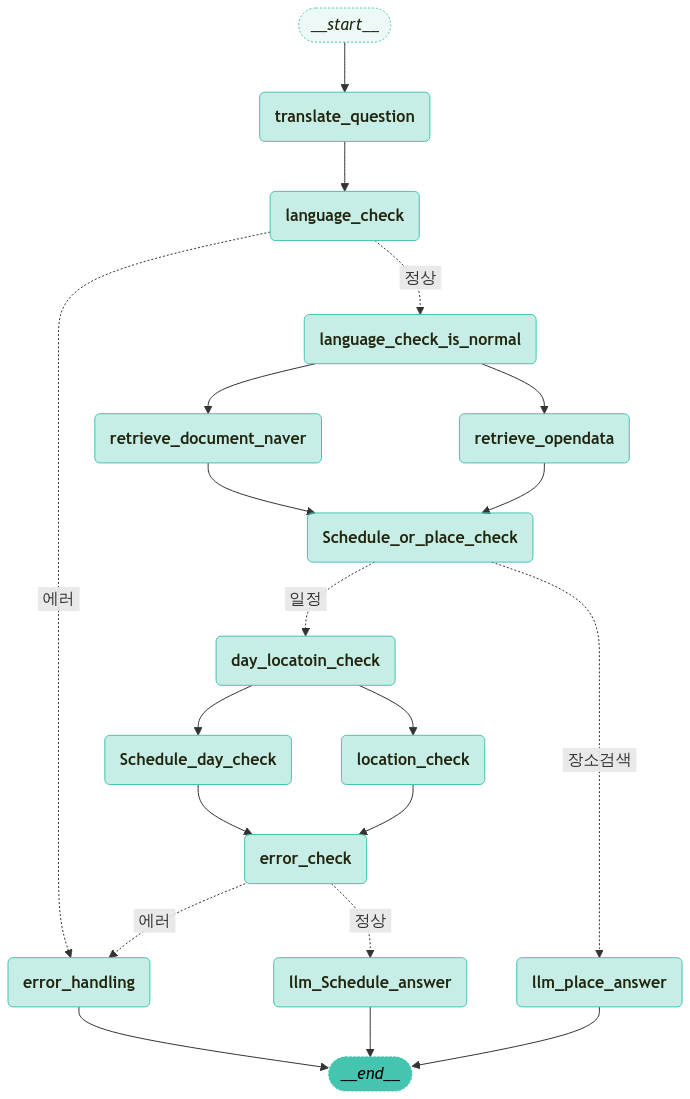

In [22]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)